# Ribbon dispersion

Na głowie kwietny ma wianek w ręku zielony badylek a przed nią bierzy baranek a nad nią lata motylek.

In [ ]:
from tinyarray import array as ta

# Pauli matrices
sigma0 = ta([[1, 0], [0, 1]])
sigmax = ta([[0, 1], [1, 0]])
sigmay = ta([[0, -1j], [1j, 0]])
sigmaz = ta([[1, 0], [0, -1]])

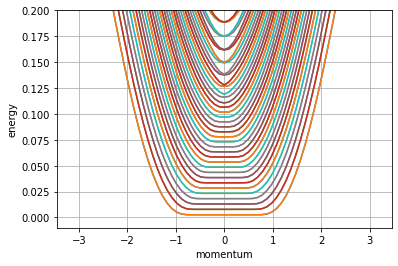

In [ ]:
lat = kwant.lattice.square()
syst = kwant.Builder(kwant.TranslationalSymmetry((-1, 0)))

Wy = 100

def hop_x(to_site, from_site, t, B):
    x, y = to_site.pos
    return -t * np.exp(1j * B * (y-(Wy-1)/2)) * sigma0

def hop_y(to_site, from_site, t):
    x, y = to_site.pos
    return -t * sigma0

def onsite(site, t):
    x, y = site.pos
    return  4 * t * sigma0

# onsite 
for ny in range(Wy):
    syst[lat(0, ny)] = onsite
    
# x-direction hoppings
for ny in range(0,Wy):
    syst[lat(0,ny),lat(1,ny)] = hop_x
    
# y-direction hoppings
for ny in range(1,Wy):
    syst[lat(0,ny-1),lat(0,ny)] = hop_y


## PBC boundary: be very carefull to add properly if needed
syst[lat(0, Wy-1), lat(0, 0)] =  hop_y
    
fsyst = syst.finalized()

fig, ax = plt.subplots(1, 1)
ax.set_xlabel("momentum")
ax.set_ylabel("energy")
ax.set_ylim(-0.01, 0.2)

Bcrit = 2*np.pi/Wy
params = dict( B=Bcrit/3, t=1/8)

kwant.plotter.bands(fsyst, ax=ax, params=params)
ax.grid()

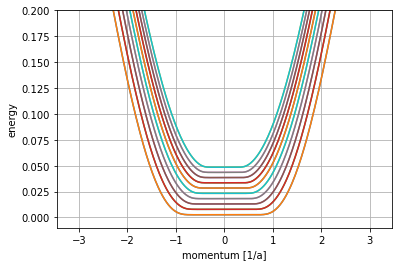

In [ ]:

#### dictionary containing the parameters
params = dict( t = 1/8, B = Bcrit/3 )

## Lead bands: calculation with a better control
#              sparse matrix diagonlization

# prepare H_0 and V for our lead
ham0  = fsyst.cell_hamiltonian(params=params, sparse=True)  #.tocsc()

_hop  = fsyst.inter_cell_hopping(params=params, sparse=True)
shp = (_hop.shape[0], _hop.shape[0] - _hop.shape[1])
_zeros = sp.coo_matrix( shp, dtype=complex)
vhop = sp.hstack( [_hop, _zeros] )                          #.tocsc()

momenta=np.linspace(-np.pi, np.pi, 301)
ens = []


for kpar in momenta:
    # H_k = H_0 + V e^-ik + V^\dagger e^ik
    hmat  = vhop * np.exp(-1j*(kpar)) 
    hmat += hmat.conjugate().transpose() + ham0
    
    #evals = la.eigh( hmat, eigvals_only=True ) ## dense solver
    evals = lsp.eigsh( hmat, k=20, return_eigenvectors=False,
                       which='LM', sigma=0.01, tol=10**(-8) )

    ens.append(np.sort(evals))


plt.grid()
#plt.xlim(-1, 1)
plt.ylim(-0.01, 0.2)
plt.xlabel('momentum [1/a]')
plt.ylabel('energy')

#plt.plot(momenta,ens,'.',ms=1)
plt.plot(momenta,ens)
plt.show()